<a href="https://colab.research.google.com/github/youngyoung-0/algorithms/blob/main/python_ML_study/Bidirectional_LSTM_NER_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [143]:
import re
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import urllib.request

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import Counter


In [144]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device : {device}')

Using device : cuda


In [145]:
url = "https://raw.githubusercontent.com/Franck-Dernoncourt/NeuroNER/master/neuroner/data/conll2003/en/train.txt"
file_name = 'train.text'
urllib.request.urlretrieve(url,filename=file_name)

('train.text', <http.client.HTTPMessage at 0x7d387ef2f260>)

In [146]:
for line in open(file_name, 'r').readlines() [:20]:
  print(line)

-DOCSTART- -X- -X- O



EU NNP B-NP B-ORG

rejects VBZ B-VP O

German JJ B-NP B-MISC

call NN I-NP O

to TO B-VP O

boycott VB I-VP O

British JJ B-NP B-MISC

lamb NN I-NP O

. . O O



Peter NNP B-NP B-PER

Blackburn NNP I-NP I-PER



BRUSSELS NNP B-NP B-LOC

1996-08-22 CD I-NP O



The DT B-NP O

European NNP I-NP B-ORG



In [147]:
tagged_sentences = []
sentence = []

In [148]:
for line in open(file_name, encoding='utf-8'):
  if len(line) == 0 or line.startswith('-DOCSTART') or line[0] == '\n':
    if len(sentence) > 0:
      tagged_sentences.append(sentence)
      sentence = []
    continue
  word, post_tag, chunk_tag, ner = line.split(" ")
  ner = re.sub('\n', '', ner)
  word = word.lower()
  sentence.append((word, ner))

print(f'전체 샘플 개수 : {len(tagged_sentences)}')

전체 샘플 개수 : 14041


In [149]:
# N to N model
inputs, labels = [], []

for pairs in tagged_sentences:
  word, tags = zip(*pairs)
  inputs.append(word)
  labels.append(tags)

print(inputs[0])
print(labels[0])

print('샘플의 최대 길이 : {}'.format(max([len(w) for w in inputs])))
print('샘풀의 평균 길이 : {:.4F}'.format(np.mean([len(w) for w in inputs])))


('eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.')
('B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O')
샘플의 최대 길이 : 113
샘풀의 평균 길이 : 14.5019


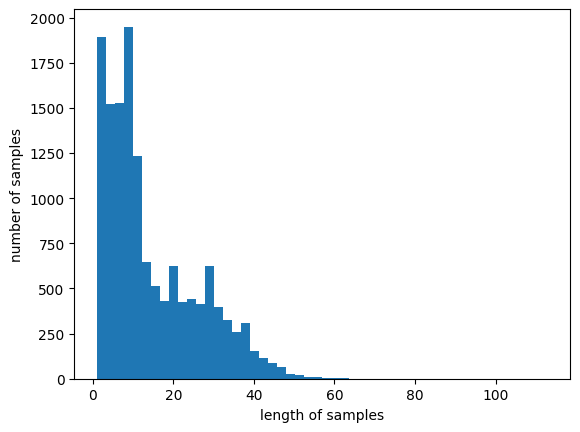

In [150]:
plt.hist([len(s) for s in inputs], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [151]:
MAX_LENGTH = 60
MAX_WORDS = 4000

In [152]:
train_sentences, test_sentences, train_labels, test_labels = train_test_split(inputs, labels, test_size=0.2, random_state=42)
print(f"train : {len(train_sentences)}, test : {len(test_sentences)}")


train : 11232, test : 2809


In [153]:
class Vocabulary :
  def __init__(self, max_words=None):
    self.word2idx = {'<PAD>' : 0, '<OOV>' : 1}
    self.idx2word = {0 : '<PAD>', 1 : '<OOV>' }
    self.max_words = max_words

  def build_vocab(self, sentences):
    word_freq = Counter()
    for sentence in sentences:
      word_freq.update(sentence)

    # 빈도순으로 정렬
    most_common = word_freq.most_common(self.max_words -2  if self.max_words else None)

    for idx, (word, _) in enumerate(most_common, start = 2):
      self.word2idx[word] = idx
      self.idx2word[idx] = word

  def encoding(self, sentences):
    return [self.word2idx.get(word, 1) for word in sentences]

  def decoding(self, sentences):
    return [self.idx2word.get(idx) for idx in sentences]

  def __len__(self):
    return len(self.word2idx)

In [154]:
# Entity와 Tag vocabulary 생성
entity_vocab = Vocabulary(max_words=MAX_WORDS)
entity_vocab.build_vocab(train_sentences)

tag_vocab = Vocabulary(max_words=None)
tag_vocab.build_vocab(train_labels)

vocab_size = len(entity_vocab)
tag_size = len(tag_vocab)

print(f'단어 집합의 크기: {vocab_size}')
print(f'개체명 태깅 정보 집합의 크기: {tag_size}')
print(f'Tag vocabulary: {tag_vocab.word2idx}')

단어 집합의 크기: 4000
개체명 태깅 정보 집합의 크기: 11
Tag vocabulary: {'<PAD>': 0, '<OOV>': 1, 'O': 2, 'B-LOC': 3, 'B-PER': 4, 'B-ORG': 5, 'I-PER': 6, 'I-ORG': 7, 'B-MISC': 8, 'I-MISC': 9, 'I-LOC': 10}


In [155]:
# 시퀀스 인코딩 패딩
def pad_sequence(sequences, max_len, pad_value = 0):
  padded = []
  for seq in sequences:
    if len(seq) < max_len:
      seq = seq + [pad_value] * (max_len - len(seq))
    else:
      seq = seq[:max_len]
    padded.append(seq)
  return np.array(padded)


In [156]:
x_train = [entity_vocab.encoding(sent) for sent in train_sentences ]
y_train = [tag_vocab.encoding(sent) for sent in train_labels]
x_test = [entity_vocab.encoding(sent) for sent in test_sentences ]
y_test = [tag_vocab.encoding(sent) for sent in test_labels]

x_train_padded = pad_sequence(x_train, MAX_LENGTH)
y_train_padded = pad_sequence(y_train, MAX_LENGTH)
x_test_padded = pad_sequence(x_test, MAX_LENGTH)
y_test_padded = pad_sequence(y_test, MAX_LENGTH)

print(f"padded sampel : {x_train_padded[0]} , {y_train_padded[0]}")


padded sampel : [ 454  127  119   13   95    9  149  212    6 1797   10   31    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0] , [2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [157]:
# Pytorch Dataset
class NERDataset(Dataset):
  def __init__(self, x, y):
    self.x = torch.LongTensor(x)
    self.y = torch.LongTensor(y)

  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

In [158]:
train_dataset = NERDataset(x_train_padded, y_train_padded)
test_dataset = NERDataset(x_test_padded, y_test_padded)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [159]:
# Bi-LSTM 모델 정의
class BiLSTM_NER(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, tag_size):
    super(BiLSTM_NER, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=1, bidirectional=True, batch_first=True)
    self.fc = nn.Linear(hidden_dim, tag_size)

  def forward(self,x):
    embedded = self.embedding(x)
    lstm_out, _ = self.lstm(embedded)
    output = self.fc(lstm_out)
    return output

In [160]:
# 모델 초기화
model = BiLSTM_NER(vocab_size, embedding_dim = 128, hidden_dim = 256, tag_size=tag_size).to(device)
print(model)
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")


BiLSTM_NER(
  (embedding): Embedding(4000, 128)
  (lstm): LSTM(128, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=11, bias=True)
)
Total parameters: 779019


In [161]:
# Loss와 Optimizer
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [162]:
# 학습 함수
def train_epoch(model, loader, criterion, optimizer, device):
  model.train()
  epoch_loss = 0
  correct = 0
  total = 0

  for x_batch, y_batch in loader:
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)

    optimizer.zero_grad()
    outputs = model(x_batch)

    # reshape
    # outputs를 재형성하여 criterion에 전달
    outputs = outputs.view(-1, tag_size)
    y_batch = y_batch.view(-1)

    loss = criterion(outputs, y_batch) # 재형성된 outputs 사용
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item() # total_loss 대신 epoch_loss 사용

    # Accurancy 계산 (padding 제외)
    pred = outputs.argmax(dim =1)
    mask = y_batch != 0
    correct += ((pred == y_batch) & mask).sum().item()
    total += mask.sum().item()
  return epoch_loss / len(loader), correct / total

In [163]:
# 평가 함수
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            outputs = model(X_batch)
            outputs = outputs.view(-1, tag_size)
            y_batch = y_batch.view(-1)

            loss = criterion(outputs, y_batch)
            total_loss += loss.item()

            pred = outputs.argmax(dim=1)
            mask = y_batch != 0
            correct += ((pred == y_batch) & mask).sum().item()
            total += mask.sum().item()

    return total_loss / len(loader), correct / total


In [164]:
# 학습 실행
num_epochs = 10
train_losses, val_losses = [],[]
train_accs, val_accs = [], []

print('학습 시작..')
for epoch in range(num_epochs):
  train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
  val_loss, val_acc = evaluate(model, test_loader, criterion, device)

  train_losses.append(train_loss)
  val_losses.append(val_loss)
  train_accs.append(train_acc)
  val_accs.append(val_acc)
  print(f'Epoch {epoch+1}/{num_epochs}')
  print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
  print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}\n')

학습 시작..
Epoch 1/10
Train Loss: 0.5626, Train Acc: 0.8586
Val Loss: 0.3382, Val Acc: 0.9028

Epoch 2/10
Train Loss: 0.2574, Train Acc: 0.9242
Val Loss: 0.2232, Val Acc: 0.9355

Epoch 3/10
Train Loss: 0.1680, Train Acc: 0.9509
Val Loss: 0.1927, Val Acc: 0.9443

Epoch 4/10
Train Loss: 0.1242, Train Acc: 0.9638
Val Loss: 0.1691, Val Acc: 0.9512

Epoch 5/10
Train Loss: 0.0950, Train Acc: 0.9725
Val Loss: 0.1598, Val Acc: 0.9533

Epoch 6/10
Train Loss: 0.0728, Train Acc: 0.9790
Val Loss: 0.1616, Val Acc: 0.9557

Epoch 7/10
Train Loss: 0.0563, Train Acc: 0.9838
Val Loss: 0.1800, Val Acc: 0.9544

Epoch 8/10
Train Loss: 0.0429, Train Acc: 0.9879
Val Loss: 0.1727, Val Acc: 0.9554

Epoch 9/10
Train Loss: 0.0326, Train Acc: 0.9909
Val Loss: 0.1826, Val Acc: 0.9573

Epoch 10/10
Train Loss: 0.0241, Train Acc: 0.9936
Val Loss: 0.2034, Val Acc: 0.9554



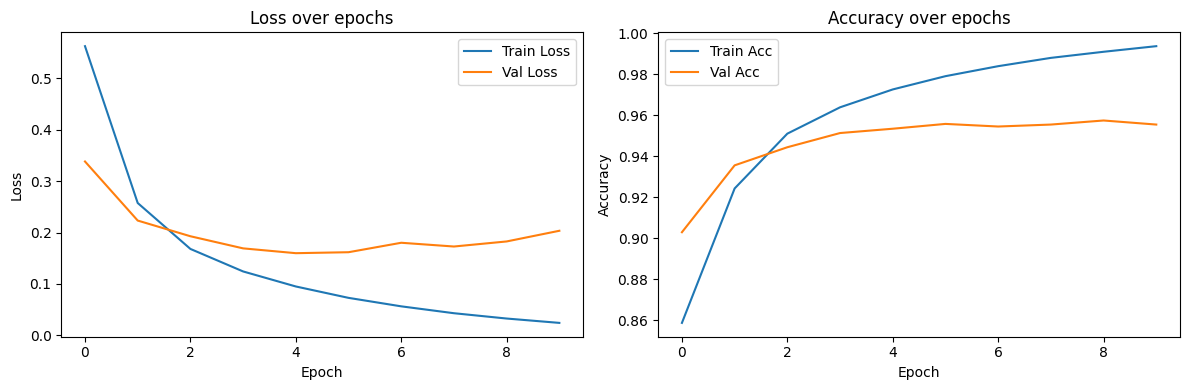

Final Test Accuracy: 95.54%


In [165]:
# 학습 결과 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Loss over epochs')

ax2.plot(train_accs, label='Train Acc')
ax2.plot(val_accs, label='Val Acc')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.set_title('Accuracy over epochs')

plt.tight_layout()
plt.show()

print(f"Final Test Accuracy: {val_accs[-1] * 100:.2f}%")

In [168]:
# 추론 함수
def predict(model, sentence, entity_vocab, tag_vocab, max_len, device):
    model.eval()

    # 문장을 토큰화하고 인코딩
    words = sentence.lower().split()
    encoded = entity_vocab.encoding(words)
    padded = pad_sequence([encoded], max_len)[0]

    # 텐서로 변환
    input_tensor = torch.LongTensor(padded).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        predictions = output.argmax(dim=-1).squeeze(0).cpu().numpy()

    # 결과 출력
    results = []
    for i, word in enumerate(words):
        if i < len(predictions):
            tag_idx = predictions[i]
            tag = tag_vocab.idx2word.get(tag_idx, '?')
            if tag != '<PAD>':
                results.append((word, tag))

    return results

In [169]:
# 테스트 추론
test_sample = "EU gave German call to take British people"
print(f"\n테스트 문장: {test_sample}")
print("\n예측 결과:")

predictions = predict(model, test_sample, entity_vocab, tag_vocab, MAX_LENGTH, device)
for word, tag in predictions:
    print(f'{word} : {tag.upper()}')



테스트 문장: EU gave German call to take British people

예측 결과:
eu : B-LOC
gave : O
german : B-MISC
call : O
to : O
take : O
british : B-MISC
people : O


In [ ]:
# 테스트 추론
test_sample = "EU gave German call to take British people"
print(f"\n테스트 문장: {test_sample}")
print("\n예측 결과:")

predictions = predict(model, test_sample, entity_vocab, tag_vocab, MAX_LENGTH, device)
for word, tag in predictions:
    print(f'{word} : {tag.upper()}')